In [1]:
import numpy as np
import pandas as pd

## 1. Recommendation system

Implementing a recommendation system is critical for businesses and digital platforms that want to thrive in today's competitive environment. These systems use data-driven personalization to tailor content, products, and services to individual user preferences. The latter improves user engagement, satisfaction, retention, and revenue through increased sales and cross-selling opportunities. In this section, you will attempt to implement a recommendation system by identifying similar users' preferences and recommending movies they watch to the study user. 

To be more specific, you will implement your version of the [**LSH algorithm**](https://www.learndatasci.com/tutorials/building-recommendation-engine-locality-sensitive-hashing-lsh-python/), which will take as input the user's preferred genre of movies, find the most similar users to this user, and recommend the most watched movies by those who are more similar to the user. 

__Data__: The data you will be working with can be found [here](https://www.kaggle.com/datasets/vodclickstream/netflix-audience-behaviour-uk-movies).

Looking at the data, you can see that there is data available for each user for the movies the user <ins>clicked on</ins>. Gather the __title and genre__ of the __maximum top 10 movies__ that each user clicked on regarding the __number of clicks__.

### 1.1. Max top 10 movies

In [ ]:
import numpy as np
import pandas as pd
import nltk
from nltk.stem import *
from nltk.corpus import stopwords
from collections import Counter


In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\egabd\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Load the dataset
data = pd.read_csv('vodclickstream_uk_movies_03.csv')


In [ ]:
data.head()

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287


In [ ]:
# Group data by user ID and movie title, count clicks, and sort in descending order
result = data.groupby(['title', 'genres']).size().reset_index(name='clicks')
result_sorted = result.sort_values(by='clicks', ascending=False).head(10)[['title', 'genres', 'clicks']]

result_sorted

,title,genres,clicks
1035,Black Mirror: Bandersnatch,"Drama, Mystery, Sci-Fi, Thriller",6436
1207,Bright,"Action, Fantasy, Thriller",3110
705,Avengers: Age of Ultron,"Action, Adventure, Sci-Fi",2898
589,Annihilation,"Adventure, Drama, Horror, Mystery, Sci-Fi, Thr...",2699
2967,Hot Fuzz,"Action, Comedy, Mystery, Thriller",2674
1761,Deadpool,"Action, Adventure, Comedy, Sci-Fi",2576
1018,Bird Box,"Drama, Horror, Sci-Fi",2549
2221,FYRE: The Greatest Party That Never Happened,"Documentary, Music",2332
6399,The Big Short,"Biography, Comedy, Drama, History",2204
6826,The Hitman's Bodyguard,"Action, Comedy, Crime, Thriller",2179


### 1.2 Minhash Signatures 
Using the movie genre and user_ids, try to implement your min-hash signatures so that users with similar interests in a genre appear in the same bucket. 

__Important note:__ You must write your minhash function from scratch.  You are not permitted to use any already implemented hash functions.  Read the class materials and, if necessary, conduct an internet search.  The description of hash functions in the [book](http://infolab.stanford.edu/~ullman/mmds/ch3n.pdf) may be helpful as a reference.


To create a min-hash signatures, we first need to create a signature matrix (rows = hashes, columns = user_index). 

Let's start by copying only the columns user_id and genres from the original dataset. 

In [ ]:
data_minhash = data[['user_id', 'genres']].copy()
data_minhash

,user_id,genres
0,1dea19f6fe,"Comedy, Drama, Romance"
1,544dcbc510,"Fantasy, Horror, Mystery, Thriller"
2,7cbcc791bf,"Action, Thriller"
3,ebf43c36b6,"Action, Drama"
4,a57c992287,"Animation, Action, Adventure, Comedy, Family, ..."
...,...,...
671731,57501964fd,Talk-Show
671732,d4fcb079ba,"Animation, Action, Adventure, Family, Sci-Fi"
671733,4a14a2cd5a,"Action, Adventure, Sci-Fi"
671734,0b8163ea4b,"Documentary, Music"


In [ ]:
# Check for the NA values 
# There are no NA values
data_minhash['genres'].isna().sum()

0

Now, we need to preprocess the genres column for future vocabulary creation

In [ ]:
# Preprocess the genres column (stemming, tokenize, stopwords)
def preprocess_column(df_column):
    stemmer = PorterStemmer()
    lst_stopwords = stopwords.words('english')
    return df_column.apply(lambda row: [stemmer.stem(word) for word in nltk.word_tokenize(row) if not word in lst_stopwords])

In [ ]:
data_minhash['genres_clean'] = preprocess_column(data_minhash.genres)

In [ ]:
data_minhash.head()

,user_id,genres,genres_clean
0,1dea19f6fe,"Comedy, Drama, Romance","[comedi, ,, drama, ,, romanc]"
1,544dcbc510,"Fantasy, Horror, Mystery, Thriller","[fantasi, ,, horror, ,, mysteri, ,, thriller]"
2,7cbcc791bf,"Action, Thriller","[action, ,, thriller]"
3,ebf43c36b6,"Action, Drama","[action, ,, drama]"
4,a57c992287,"Animation, Action, Adventure, Comedy, Family, ...","[anim, ,, action, ,, adventur, ,, comedi, ,, f..."


In [ ]:
# By printing the unique genres we can notice that 
# there are values such as 'NOT AVAILABLE' and there is also a comma
# and we should remove it: 
unique_genres = set(genre for sublist in data_minhash['genres_clean'] for genre in sublist)
unique_genres

{',',
 'action',
 'adventur',
 'anim',
 'avail',
 'biographi',
 'comedi',
 'crime',
 'documentari',
 'drama',
 'famili',
 'fantasi',
 'film-noir',
 'histori',
 'horror',
 'music',
 'mysteri',
 'new',
 'not',
 'reality-tv',
 'romanc',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western'}

In [ ]:
# Since we have noticed that some genres include 'NOT AVAILABLE' value 
# We need to remove it 

# Preprocess string (stemming, tokenize, stopwords)
def preprocess_string(string):
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in nltk.word_tokenize(string)]

# Preprocess the 'NOT AVAILABLE' as we did for genres column
remove_words = preprocess_string(', NOT AVAILABLE')

# Iterate over the DataFrame and update each row's genres_clean
for index, row in data_minhash.iterrows():
    # Remove the unwanted words from genres_clean list
    data_minhash.at[index, 'genres_clean'] = [word for word in row['genres_clean'] if word not in remove_words]


Vocabulary of unique genres from the genres_clean column. There 25 unique genres. 

In [ ]:
unique_genres = list(set(genre for sublist in data_minhash['genres_clean'] for genre in sublist))
unique_genres

['fantasi',
 'talk-show',
 'drama',
 'romanc',
 'mysteri',
 'documentari',
 'short',
 'music',
 'horror',
 'sci-fi',
 'histori',
 'adventur',
 'sport',
 'famili',
 'crime',
 'reality-tv',
 'biographi',
 'thriller',
 'action',
 'comedi',
 'anim',
 'war',
 'film-noir',
 'new',
 'western']

The same user could appear in several rows. We have to group all rows by user_id to have a total list of genres in which the user is interested in.

In [ ]:
def accumulate_genres(series):
    return set().union(*series)

# Group by user_id
data_minhash = data_minhash.groupby(by='user_id').agg({'genres_clean': accumulate_genres}).reset_index()
data_minhash['genres_clean'] = data_minhash['genres_clean'].map(list)
data_minhash.head()

,user_id,genres_clean
0,00004e2862,"[thriller, crime, drama]"
1,000052a0a0,"[fantasi, crime, thriller, drama, action, sci-..."
2,000090e7c8,"[thriller, mysteri, sci-fi]"
3,000118a755,[horror]
4,000296842d,"[mysteri, thriller, drama, sci-fi]"


Let's now see if there are any empty lists in genres_clean

In [ ]:
count_empty_lists = (data_minhash['genres_clean'].apply(lambda x: x == [])).sum()

print("Number of empty lists:", count_empty_lists)

Number of empty lists: 3607


We need to remove these rows with empty genres lists

In [ ]:
# Filter out rows where 'genres_clean' has an empty list
data_minhash = data_minhash[data_minhash['genres_clean'].apply(lambda x: x != [])]


In [ ]:
data_minhash

,user_id,genres_clean
0,00004e2862,"[thriller, crime, drama]"
1,000052a0a0,"[fantasi, crime, thriller, drama, action, sci-..."
2,000090e7c8,"[thriller, mysteri, sci-fi]"
3,000118a755,[horror]
4,000296842d,"[mysteri, thriller, drama, sci-fi]"
...,...,...
161913,fffd9bf758,"[crime, mysteri, documentari]"
161914,fffe7b777b,"[thriller, drama, sci-fi]"
161915,fffeac83be,"[war, crime, biographi, drama, histori, myster..."
161916,ffff2c5f9e,"[thriller, mysteri, action, documentari, comedi]"


the index number != row number 
we have to reset the index

In [ ]:
data_minhash.reset_index(drop=True, inplace=True)
data_minhash

,user_id,genres_clean
0,00004e2862,"[thriller, crime, drama]"
1,000052a0a0,"[fantasi, crime, thriller, drama, action, sci-..."
2,000090e7c8,"[thriller, mysteri, sci-fi]"
3,000118a755,[horror]
4,000296842d,"[mysteri, thriller, drama, sci-fi]"
...,...,...
158306,fffd9bf758,"[crime, mysteri, documentari]"
158307,fffe7b777b,"[thriller, drama, sci-fi]"
158308,fffeac83be,"[war, crime, biographi, drama, histori, myster..."
158309,ffff2c5f9e,"[thriller, mysteri, action, documentari, comedi]"


Now we need to create signature_dict which will store the index for each genre.

In [ ]:
signature_dict = {}
for i, genre in enumerate(unique_genres):
    signature_dict[genre] = i
signature_dict

{'fantasi': 0,
 'talk-show': 1,
 'drama': 2,
 'romanc': 3,
 'mysteri': 4,
 'documentari': 5,
 'short': 6,
 'music': 7,
 'horror': 8,
 'sci-fi': 9,
 'histori': 10,
 'adventur': 11,
 'sport': 12,
 'famili': 13,
 'crime': 14,
 'reality-tv': 15,
 'biographi': 16,
 'thriller': 17,
 'action': 18,
 'comedi': 19,
 'anim': 20,
 'war': 21,
 'film-noir': 22,
 'new': 23,
 'western': 24}

**Hash Functions Creation**

Now, we need to create hash functions. 

The inputs for each hash function will be a genre index.

The output will be a hashed value.

Our hash function is as the following:
$$hash(x) = (a_1 x + a_2 x + a_3 x + a_4) \mod m$$

where:
- $ m = 29 $ (should be a prime number greater than max(x) = 24);
- $ x = \{0,1,2,\ldots, 24\}  $ ;
- $ a_i = \{0,1,2,\ldots, 28\}  $ ;


In [ ]:
N = 25  # Number of elements in signature_dict
num_hashs = 12  # Number of hash functions
m = 29  # A prime number as modulus, larger than N

# Generating random coefficients a1, a2, a3, and a4 for each hash function
a_values = np.random.randint(m, size=[num_hashs, 4])

In [ ]:
a_values

array([[12,  0,  0, 12],
       [16,  2, 15, 22],
       [13, 12, 14, 12],
       [13,  3, 19, 19],
       [22, 21,  8,  4],
       [ 5, 11, 22, 10],
       [11, 13,  6,  0],
       [ 6, 19, 11, 12],
       [28,  5, 10, 11],
       [ 9, 10, 21, 16],
       [ 4, 17, 20,  9],
       [12, 24, 12, 13]])

In [ ]:
signature_matrix = np.ones((num_hashs, data_minhash.shape[0])) * np.inf

In [ ]:
signature_matrix

array([[inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       ...,
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf]])

In [ ]:
# Define the hash function
def hash_function(x, a_values, m):
    return (a_values[:,0] * x + a_values[:,1] * x + a_values[:,2] * x + a_values[:,3]) % m

In [ ]:
# Building the signature matrix
for index, vector in data_minhash.iterrows():
    shingles = vector['genres_clean']
    genre_index_vector = np.array([signature_dict[shingle] for shingle in shingles])
    
    for each_genre in genre_index_vector:
        hashed_genre = hash_function(each_genre, a_values, m)
        signature_matrix[:, index] = np.minimum(signature_matrix[:, index], hashed_genre)

In [ ]:
signature_matrix

array([[ 6.,  2.,  2., ...,  1.,  2.,  6.],
       [ 1.,  0.,  0., ...,  1.,  3.,  1.],
       [ 3.,  3.,  8., ...,  3.,  4.,  3.],
       ...,
       [ 0.,  0.,  0., ...,  2.,  0.,  9.],
       [ 3.,  1.,  1., ...,  0.,  5.,  3.],
       [17.,  1.,  2., ...,  0.,  2., 18.]])

In [ ]:
# Counting the number of inf values
num_inf_values = np.sum(np.isinf(signature_matrix))

print("Number of inf values:", num_inf_values)

Number of inf values: 0


In [ ]:
signature_matrix = [[int(value) for value in row] for row in signature_matrix]

To create a min-hash signatures so that users with similar interests in a genre appear in the same bucket. 

First, we need to divide the signature_matrix rows into several bands and we will look for similar user genre interests. If band = 1 than we will look for **exactly the same** genre interests, which result in little number of pairs. However, if the number of bands is 12 then we will have too much pairs that have at least 1 same genre. Therefore, it is decided to take 3 bands with 4 rows each ([source](https://www.pinecone.io/learn/series/faiss/locality-sensitive-hashing/)).

In [ ]:
def bucketsCreation(signature_matrix, bands):
    signature_matrix_df = pd.DataFrame(signature_matrix)

    num_hashes, num_users = signature_matrix_df.shape
    band_size = num_hashes // bands
    min_hash_signatures = {}

    for j in range(num_users):
        for i in range(bands):
            # Extract the current band for this column using .iloc
            start_row = i * band_size
            end_row = start_row + band_size
            band = signature_matrix_df.iloc[start_row:end_row, j]

            # Create a hashable identifier for the band
            band_id = tuple(band.tolist() + [i])

            # Update the bucket with the current column index
            if band_id in min_hash_signatures:
                min_hash_signatures[band_id].add(j)
            else:
                min_hash_signatures[band_id] = {j}

    # Filter out buckets with only one column index
    min_hash_sign_buckets = [bucket for bucket in min_hash_signatures.values() if len(bucket) > 1]

    return min_hash_sign_buckets


In [ ]:
min_hash_pairs = bucketsCreation(signature_matrix, bands = 3)

In [ ]:
len(min_hash_pairs)

2017

Here, min_hash_pairs have 2017 buckets (sets), where each set represents the users id that have the similar genre interests. 

# 2. Grouping Users together!

## 2.1 Getting your data + feature engineering


### Access to the data

In [ ]:
df  = pd.read_csv('vodclickstream_uk_movies_03.csv', index_col=0)

In [199]:
df = df[df['duration'] >= 0].copy()

In [200]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [201]:
df['release_date'] = df['release_date'].apply(lambda x: x[:4] if x is not np.nan else np.nan)

In [202]:
df.dropna(subset=['release_date'], inplace=True)

In [203]:
df = df[df['release_date'] != 'NOT ']

In [204]:
df['release_date'] = df['release_date'].astype(int)

In [ ]:
df['genres_list'] 

### 2.1 Sometimes, the features (variables, fields) are not given in a dataset but can be created from it; this is known as feature engineering. For example, the original dataset has several clicks done by the same user, so grouping data by user_id will allow you to create new features for each user:

a) Favorite genre (i.e., the genre on which the user spent the most time)

b) Average click duration

c) Time of the day (Morning/Afternoon/Night) when the user spends the most time on the platform (the time spent is tracked through the duration of the clicks)

d) Is the user an old movie lover, or is he into more recent stuff (content released after 2010)?

e) Average time spent a day by the user (considering only the days he logs in)

In [205]:
#Favorite genre (i.e., the genre on which the user spent the most time)
users = df.loc[df.groupby('user_id')['duration'].idxmax().values][['user_id', 'genres']].copy()
users.reset_index(drop=True, inplace=True)
users.rename(columns={'genres': 'favorite_genre'}, inplace=True)
users['avg_click_duration'] = df.groupby('user_id')['duration'].mean().values


In [206]:
users['time_of_day'] = df.groupby('user_id')['duration'].idxmax().apply(lambda x: df.loc[x, 'datetime'].hour).values
users['time_of_day'] = users['time_of_day'].apply(lambda x: 'Morning' if x>=7 and x <12 else ('Afternoon' if x >= 12 and x < 18 else 'Night'))

In [207]:
users['old_movie_lover'] = df.groupby('user_id')['release_date'].apply(lambda x: np.mean(x < 2010)).values

In [208]:
users['old_movie_lover'] = users['old_movie_lover'].apply(lambda x: 'Yes' if x > 0.5 else 'No')

In [209]:
df['date'] = df['datetime'].apply(lambda x: x.date())

In [210]:
users['avg_time_spent'] = df.groupby('user_id')['duration'].sum().values / df.groupby('user_id')['date'].nunique().values

Consider at least 10 additional features that can be generated for each user_id (you can use chatGPT or other LLM tools for suggesting features to create). Describe each of them and add them to the previous dataset you made (the one with five features). In the end, you should have for each user at least 15 features (5 recommended + 10 suggested by you).

1. Genre Diversity: The count or percentage of different genres the user has clicked on. This can indicate the user's exploration of diverse content.

2. Weekday vs. Weekend Activity Ratio: Ratio of clicks or time spent on the platform during weekdays versus weekends, providing insight into their usage patterns.

3. Session Frequency: Average frequency of user sessions per day or per week, indicating how often they visit the platform.

4. Duration of Longest Click: The duration of the longest single click made by the user, highlighting their engagement with specific content.

5. Clicks per Year: The average number of clicks made by the user per year, showing their long-term activity trend.

6. Clicks per Month: The average number of clicks made by the user per month, showing their long-term activity trend.

7. Time Spent on Latest Release: Percentage of time spent on content released within the last month or quarter, indicating their interest in recent releases.

8. Genre Preference Change Over Time: A metric showing how a user's favorite genre has evolved or changed over a certain period.

9. How many movies has user wathced from the top 100 movies(ranked by number of clicks by unique users)

10. Time Gaps Between Clicks: Average or maximum time gaps between consecutive clicks, showing if the user binge-watches or prefers spaced viewing sessions.

1. Genre Diversity (i.e., the number of different genres on which the user spent time)

In [217]:
df['genres_list'] = df['genres'].apply(lambda x: x.split(', '))

In [219]:
users['genre_diversity'] = df.groupby('user_id')['genres_list'].sum().apply(lambda x: len(list(set(x)))).values

2. Weekday vs. Weekend Activity Ratio: Ratio of clicks or time spent on the platform during weekdays versus weekends, providing insight into their usage patterns.

In [220]:
df['weekday'] = df['datetime'].apply(lambda x: x.weekday()<5)


In [221]:
users['weekday_ratio'] = df.groupby('user_id')['weekday'].mean().values

3. Session Frequency: Average frequency of user sessions per day or per week, indicating how often they visit the platform.


In [222]:
users['session_frequency_day'] = df.groupby('user_id')['datetime'].count().values / df.groupby('user_id')['date'].nunique().values 



4. Duration of Longest Click: The duration of the longest single click made by the user, highlighting their engagement with specific content.


In [223]:
users['longest_click_duration'] = df.groupby('user_id')['duration'].max().values


5-6. Clicks per Month/Year: The average number of clicks made by the user per month or per year, showing their long-term activity trend.


In [224]:
users['clicks_per_year'] = df.groupby('user_id')['datetime'].nunique().values / (df['date'].max().year - df['date'].min().year)
users['clicks_per_month'] = df.groupby('user_id')['datetime'].nunique().values / (df['date'].max().month - df['date'].min().month)


7. Time Spent on Latest Release: Percentage of time spent on content released within the last month or quarter, indicating their interest in recent releases.

In [225]:
users['time_spent_on_latest_release'] = df.groupby('user_id')['release_date'].apply(lambda x: np.mean(x >= 2018)).values

8. Genre Preference Change Over Time: A metric showing how a user's favorite genre has evolved or changed over a certain period.

In [226]:
users['genre_preference_change'] = df.groupby('user_id')['genres'].apply(lambda x: len(x) / len(set(x))).values


9. How many movies has user watched from the top 100 movies(ranked by number of clicks by unique users). This can indicate the user's interest in popular content.

In [227]:
top_100 = df.groupby('movie_id')['user_id'].nunique().sort_values(ascending=False)[:100].index.values

In [228]:
top_100_titles = df[df['movie_id'].isin(top_100)].groupby('movie_id')['title'].first().values

In [229]:
users['top_100_movies_watched'] = df.groupby('user_id')['movie_id'].apply(lambda x: len(set(x).intersection(set(top_100)))).values

10. Title Length: The character count or word count of the titles the user clicks on. This might indicate a preference for shorter or longer titles.

In [230]:
users['title_length'] = df.groupby('user_id')['title'].apply(lambda x: np.mean(x.str.len())).values

## 2.2 Choose your features (variables)!

We decided to normalize the numerical features and use LabelEncoder for the categorical features. As we are going further use KMeans clustering, I think Normalization is important part for our numerical features, as it will help to avoid the bias of the features with higher values. 

In [232]:
users_num = users.copy()

In [235]:
from sklearn.preprocessing import LabelEncoder

label_encoder_frg = LabelEncoder()
label_encoder_tod = LabelEncoder()
label_encoder_oml = LabelEncoder()
users_num['favorite_genre'] = label_encoder_frg.fit_transform(users_num['favorite_genre'])
users_num['time_of_day'] = label_encoder_tod.fit_transform(users_num['time_of_day'])
users_num['old_movie_lover'] = label_encoder_oml.fit_transform(users_num['old_movie_lover'])



In [236]:
#show mappings for categorical variables
print('Time of day mapping:')
for i, cat in enumerate(label_encoder_tod.classes_):
    print(f'{i}: {cat}')
print()
print('Old movie lover mapping:')
for i, cat in enumerate(label_encoder_oml.classes_):
    print(f'{i}: {cat}')


Time of day mapping:
0: 0
1: 1
2: 2

Old movie lover mapping:
0: 0
1: 1


In [264]:
users_num.describe()

,favorite_genre,avg_click_duration,time_of_day,old_movie_lover,avg_time_spent,genre_diversity,weekday_ratio,session_frequency_day,longest_click_duration,clicks_per_year,clicks_per_month,time_spent_on_latest_release,genre_preference_change,top_100_movies_watched,title_length
count,150566.000000,1.505660e+05,150566.000000,150566.000000,1.505660e+05,150566.000000,150566.000000,150566.000000,1.505660e+05,150566.000000,150566.000000,150566.000000,150566.000000,150566.000000,150566.000000
mean,512.367088,4.691810e+04,1.397998,0.179396,6.028587e+04,5.361821,0.638132,1.522069,1.092973e+05,1.932963,0.773185,0.173966,1.400030,0.620319,16.552875
std,300.062812,1.724922e+05,0.865593,0.383685,2.024691e+05,3.275044,0.403313,0.905026,3.035514e+05,3.058470,1.223388,0.330623,0.788165,0.943373,8.112747
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,1.000000,0.000000,1.000000,0.000000e+00,0.500000,0.200000,0.000000,1.000000,0.000000,1.000000
25%,208.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,3.000000,0.285714,1.000000,0.000000e+00,0.500000,0.200000,0.000000,1.000000,0.000000,11.000000
50%,577.000000,3.487056e+03,2.000000,0.000000,5.407000e+03,5.000000,0.800000,1.000000,6.890500e+03,1.000000,0.400000,0.000000,1.000000,0.000000,15.000000
75%,728.000000,2.741138e+04,2.000000,0.000000,4.160250e+04,7.000000,1.000000,2.000000,8.549600e+04,2.000000,0.800000,0.176471,1.500000,1.000000,20.000000
max,1028.000000,1.147194e+07,2.000000,1.000000,1.400752e+07,22.000000,1.000000,28.000000,1.823725e+07,361.500000,144.600000,1.000000,48.000000,19.000000,88.000000


In [243]:
users_num.columns


Index(['user_id', 'favorite_genre', 'avg_click_duration', 'time_of_day',
       'old_movie_lover', 'avg_time_spent', 'genre_diversity', 'weekday_ratio',
       'session_frequency_day', 'longest_click_duration', 'clicks_per_year',
       'clicks_per_month', 'time_spent_on_latest_release',
       'genre_preference_change', 'top_100_movies_watched', 'title_length'],
      dtype='object')

I tried two different approaches for normalization techniques: MinMaxScaler and L2 Normalizaer. I think MinMaxScaler is better for our case, as PCA has better variance ratio with MinMaxScaler.

In [285]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = users_num.drop('user_id', axis=1)
X_categorical = X.iloc[:, [0, 2, 3]]
X_numerical = X.iloc[:, [1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]]
normalized_X = scaler.fit_transform(X_numerical.values)

I will proceed by applying PCA on numerical variables and keeping the categorical variables intact. I decied to use PCA as it will help to reduce the dimensionality of the data by maximizing the variance of the data.

As I have 3 categorical variables, I will decide to use PCA n_components=3, so total columns of resulted data will be 6.
Although, PCA is linear method and it means it might not work well id the data structure is non-linear. Also the transformed features after PCA are less interpretable.

In [281]:
from sklearn.decomposition import PCA

# Initialize PCA and fit_transform the normalized matrix
pca = PCA()  # Set the number of components you want to retain
pca.fit(normalized_X)

# Displaying the explained variance ratio
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
print("Total Explained Variance Ratio:", sum(pca.explained_variance_ratio_))
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()

Explained Variance Ratio: [5.25373332e-01 3.53248111e-01 8.12167134e-02 2.78968337e-02
 5.51234384e-03 3.62174405e-03 2.07286653e-03 6.26512193e-04
 2.32925119e-04 1.68428707e-04 3.01894970e-05 2.27391680e-33]
Total Explained Variance Ratio: 0.9999999999999998


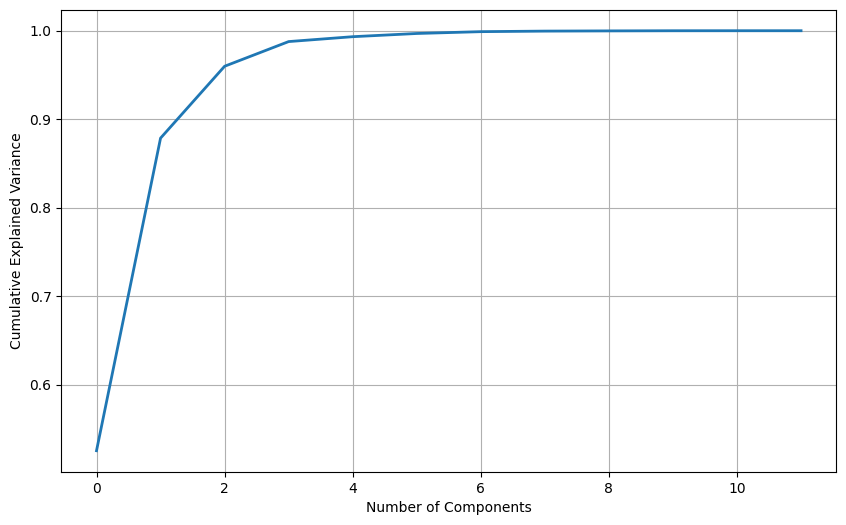

In [282]:
#plotting the cumulative variance
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance_ratio, linewidth=2)
plt.grid()
plt.axis('tight')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()


Looking at plot, we can notice that 2-3 as the number of components describe the most of data variance, so I will use n_components=3 for PCA.

In [283]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X_pca = pca.fit_transform(normalized_X)

print("Explained Variance Ratio:", pca.explained_variance_ratio_)
print("Total Explained Variance Ratio:", sum(pca.explained_variance_ratio_))

Explained Variance Ratio: [0.52537333 0.35324811 0.08121671]
Total Explained Variance Ratio: 0.9598381564044745


In [ ]:
X_pca = pd.DataFrame(X_pca, columns=['pca1', 'pca2', 'pca3'])
result_df = pd.concat([X_categorical.reset_index(drop=True), X_pca], axis=1)

In [23]:
result_df.to_csv('pca_result_df.csv', index=False)

In [2]:
result_df = pd.read_csv('pca_result_df.csv')

## 2.3 Clustering!


### 2.3.1 Implement the K-means clustering algorithm (not ++: random initialization) using MapReduce. We ask you to write the algorithm from scratch following what you learned in class.

In [3]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [25]:
import numpy as np
from pyspark.sql import SparkSession
from pyspark import SparkContext

data_points = [tuple(row) for row in np.round(result_df.values, 2)]

spark_session = SparkSession.builder.master("local[1]").appName('KMeansClustering').getOrCreate()
spark_context = SparkContext.getOrCreate()
data_rdd = spark_context.parallelize(data_points)

### MapReduce for K-means clustering algorithm

In [43]:
def assign_to_closest_centroid(point, centroids):
    closest_centroid = tuple(centroids[np.argmin([np.sum((np.array(point)-np.array(centroid))**2) for centroid in centroids])])
    return closest_centroid, point

In [44]:
def compute_new_centroids(cluster):
    new_centroid = np.mean(list(cluster), axis=0).tolist()
    return new_centroid, list(cluster)

In [45]:
def kmeans_mapreduce(data_rdd, num_clusters, max_iterations=10, tolerance=0.001):

    # Initialize centroids by randomly selecting num_clusters points
    centroids = np.array(data_rdd.takeSample(False, num_clusters, 1))
    old_centroids = np.zeros(centroids.shape)

    # Run MapReduce
    for i in range(max_iterations):

        # Map: assign each point to the closest centroid
        mapped_data = data_rdd.map(lambda point: assign_to_closest_centroid(point, centroids))

        # Reduce: compute new centroid for each cluster
        reduced_data = mapped_data.groupByKey().mapValues(compute_new_centroids).values().collect()

        old_centroids = centroids
        centroids = np.array([tuple(cluster[0]) for cluster in reduced_data])
        clusters = [list(cluster[1]) for cluster in reduced_data]

        # Check the tolerance threshold
        if np.sum((centroids - old_centroids)**2) < tolerance:
            break

    return centroids, clusters

In [46]:
def inertia(points, centroids):
    total_distance = 0

    for point in points:
        point_array = np.array(point)
        distances = []

        # Compute the distance to each centroid
        for centroid in centroids:
            centroid_array = np.array(centroid)
            distance = np.sum((point_array - centroid_array) ** 2)
            distances.append(distance)

        min_distance = min(distances)
        total_distance += min_distance

    return total_distance

In [47]:
def assign_points_to_clusters(clusters):
    clust_id = {}
    for i, cluster in enumerate(clusters):
        for point in cluster:
            clust_id[point] = i
    return clust_id

def kmeans(max_clusters, rdd,  data_points, max_iters):
    inertia_lst = []
    silhouette_lst = []
    kmeans_results = {}

    for k in range(1, max_clusters+1):
        centroids, clusters = kmeans_mapreduce(rdd, k, max_iters)
        print(f'k={k} done')

        clust_index = assign_points_to_clusters(clusters)
        res_inertia = inertia(data_points, centroids)
        inertia_lst.append(res_inertia)
        
        if k == 0:
            silhouette_lst.append(0)
        else:
            silhouette_lst.append(silhouette_score(data_points, [clust_index[point] for point in data_points]))

        kmeans_results[k] = {"centroids": centroids, "clusters": [clust_index[point] for point in data_points]}

    return inertia_lst, silhouette_lst, kmeans_results

In [ ]:
inertia_values, silhouette_values, kmeans_results = kmeans(10, data_rdd, data_points, 10)

### 2.3.2 Find an optimal number of clusters. Use at least two different methods. If your algorithms provide diverse optimal K's, select one of them and explain why you chose it.

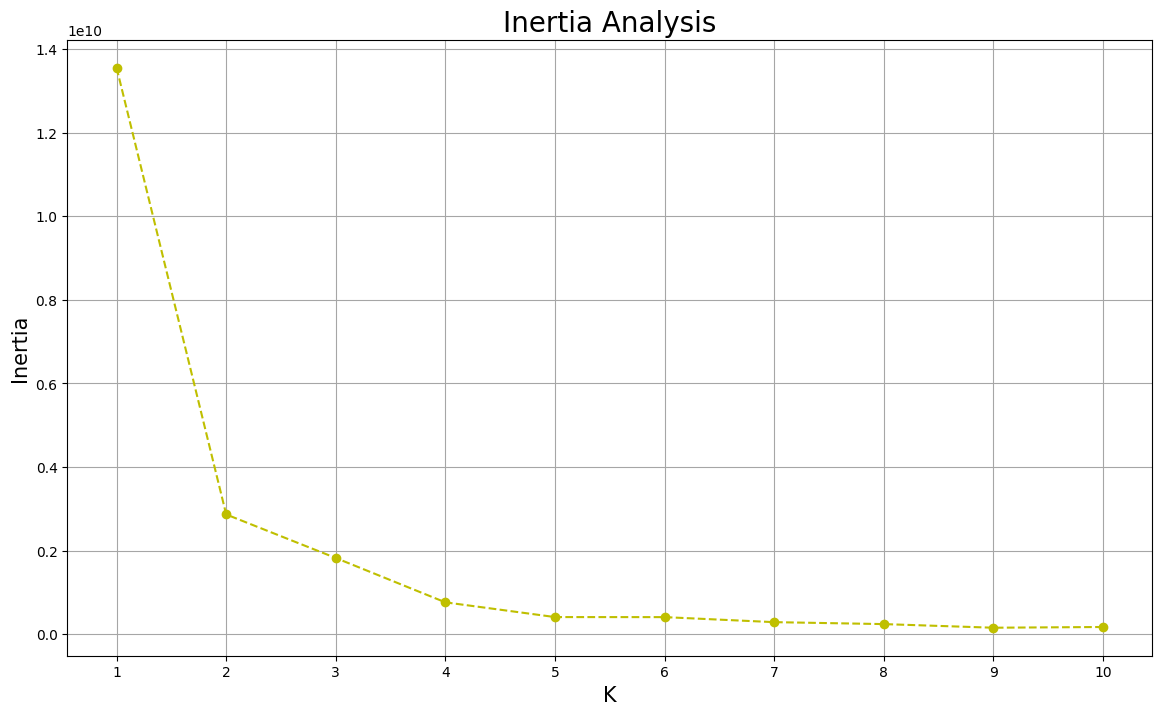

In [59]:
plt.figure(figsize=(14, 8))
plt.xticks(range(1, len(inertia_values) + 1))
plt.ylabel("Inertia", fontsize=15)
plt.xlabel("K", fontsize=15)
plt.title("Inertia Analysis", fontsize=20)
plt.grid(True, which='both', color='0.65', linestyle='-')
plt.plot(range(1, len(inertia_values) + 1), inertia_values, '--yo')
plt.show()

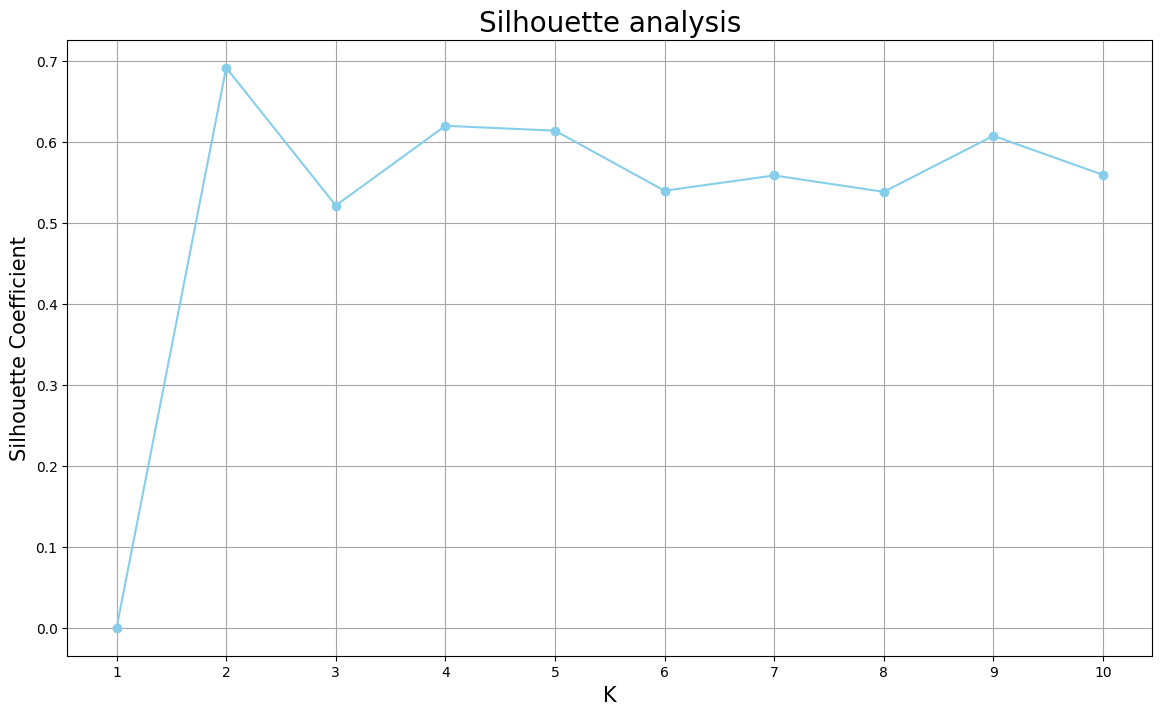

In [58]:
# Set figure size
plt.figure(figsize=(14, 8))
# Plot silhouette scores vs. number of clusters
plt.xticks(range(1, len(silhouette_values) + 1))
plt.ylabel("Silhouette Coefficient", fontsize=15)
plt.xlabel("K", fontsize=15)
plt.title("Silhouette analysis", fontsize=20)
plt.grid(True, which='both', color='0.65', linestyle='-')
plt.plot([x for x in range(1, len(silhouette_values) + 1)], silhouette_values, 'o-', color='skyblue')
plt.show()

From these two metrics analysis, we can say that the optimal number of clusters is 2. However with our prior intuition that 2 clusters is small partition, we are more likely to choose 4 as number of clusters. In case of Silhouette Analysis, it shows that 2 is optimal choice for our k, but then score start to fluctuate and it is not stable. So, I will choose 4 as number of clusters.

### 2.3.3 Run the algorithm on the data obtained from the dimensionality reduction.

In [71]:
kmeans4_centroids, kmeans_clusters = kmeans_mapreduce(data_rdd, 4)

23/12/17 16:19:15 WARN TaskSetManager: Stage 244 contains a task of very large size (17228 KiB). The maximum recommended task size is 1000 KiB.
23/12/17 16:19:15 WARN TaskSetManager: Stage 245 contains a task of very large size (17228 KiB). The maximum recommended task size is 1000 KiB.
23/12/17 16:19:15 WARN TaskSetManager: Stage 246 contains a task of very large size (17228 KiB). The maximum recommended task size is 1000 KiB.
23/12/17 16:19:21 WARN TaskSetManager: Stage 248 contains a task of very large size (17228 KiB). The maximum recommended task size is 1000 KiB.
23/12/17 16:19:26 WARN TaskSetManager: Stage 250 contains a task of very large size (17228 KiB). The maximum recommended task size is 1000 KiB.
23/12/17 16:19:32 WARN TaskSetManager: Stage 252 contains a task of very large size (17228 KiB). The maximum recommended task size is 1000 KiB.
23/12/17 16:19:37 WARN TaskSetManager: Stage 254 contains a task of very large size (17228 KiB). The maximum recommended task size is 10

In [72]:
kmeans4_centroids

array([[ 6.88004271e+02,  1.40008644e+00,  2.01022017e-01,
        -3.30502873e-04,  2.78863070e-02, -3.00503381e-02],
       [ 9.26010104e+02,  1.40414174e+00,  1.24932822e-01,
         2.41446025e-03,  8.11973774e-02, -1.93357458e-02],
       [ 5.15051341e+02,  1.39290067e+00,  2.38269348e-01,
         1.61060329e-03, -2.19082876e-02,  7.55728215e-03],
       [ 1.45209996e+02,  1.39628918e+00,  1.54392982e-01,
        -7.79449912e-03, -5.23538148e-02,  2.90948694e-02]])

In [73]:
kmeans4_centroids.shape

(4, 6)

### 2.3.4 Implement K-means++ from scratch and explain the differences with the results you got earlier.

In [74]:
def calculate_distances(data, centroids):
    return np.array([min([np.linalg.norm(p - i) ** 2 for i in centroids]) for p in data.values])

def choose_new_centroid(data, cuml_dist):
    random_value = np.random.rand()
    new_centroid_index = np.searchsorted(cuml_dist, random_value)
    return data.iloc[new_centroid_index].values

def kmeans_2plus(data, k):
    centroids = [data.sample().values[0]]

    for _ in range(1, k):
        distances = calculate_distances(data, centroids)
        prob_dist = distances / distances.sum()
        cum_dist = np.cumsum(prob_dist)
        new_centroid = choose_new_centroid(data, cum_dist)
        centroids.append(new_centroid)

    return np.array(centroids)

kmeans2plus_centroids = kmeans_2plus(result_df, 4)

In [76]:
kmeans2plus_centroids

array([[ 5.42000000e+02,  0.00000000e+00,  0.00000000e+00,
        -4.71739259e-02, -9.50657733e-02,  4.24421491e-01],
       [ 8.94000000e+02,  2.00000000e+00,  0.00000000e+00,
        -3.35407595e-01,  8.40837729e-01, -9.17590213e-02],
       [ 1.40000000e+02,  2.00000000e+00,  0.00000000e+00,
        -3.35536650e-01,  8.36572534e-01,  1.30301107e-02],
       [ 6.30000000e+02,  2.00000000e+00,  0.00000000e+00,
         6.63896456e-01,  8.12630675e-01, -8.60375411e-02]])

In [77]:
kmeans2plus_centroids.shape

(4, 6)

Let's compare the results of K-means and K-means++:

In [78]:
#comparison the k-means and k-means++ centroids by taking euclidean distance
euc_dist = np.sum((kmeans4_centroids - kmeans2plus_centroids)**2)
euc_dist


398032.9187059767

**KMean vs KMean++**

We can see that euclidean difference between KMean and KMean++ centroids is 398032.9187059767, and it is quite big difference. It means that KMean++ centroids are just initialization, while KMmean centroids is algorithm with iterative nature and threshold tolereance check.

### 2.3.5 Ask ChatGPT to recommend other clustering algorithms and choose one. Explain your choice, then ask ChatGPT to implement it or use already implemented versions (e.g., the one provided in the scikit-learn library) and run it on your data. Explain the differences (if there are any) in the results. Which one is the best, in your opinion, and why?

We asked ChatGPT which clustering should we use and choose Spectral Clustering.
It uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in fewer dimensions. Spectral clustering can capture complex cluster structures and is effective for datasets with non-linear boundaries.


# CLQ

### What is the most-watched Netflix title?

![clq_1](CLQ-task_1.jpg)

### Report the average time between subsequent clicks on Netflix.com

![clq_1](CLQ-task_2.jpg)

### Provide the ID of the user that has spent the most time on Netflix

![clq_1](CLQ-task_3.jpg)

## 5. Algorithmic Question 


**Brute Force Solution**

The main difficulty of this problem is find out the optimal exam order. One possible solution could be taking all possible permutations for the exam marks array, and make calculations of final score for each permutation, and return the maximum possible score. However, the time complexity of computing a permutations for an array of $N$ elements is $ O(N!) $. The computation of the final score could have a time complexity of $ O(N^2) $, which suggest that the overall complexity of the algorithm will be $ O(N!\times N^2) $.

-------------------------------------------------------------------------

**Find a pattern**

We need to find the pattern in the behavior of the final score. 

For "easy" exam the operation will be:
$$ mark\_list_{easy} + S - p $$

For "hard" exam the operation will be:
$$ mark\_list_{hard} - (p - S) = exam_{easy} + S - p $$

Therefore, the operation for both cases is the same.

Let's now compute the final score for an array of odd/even number of elements.

-------------------------------------------------------------------------
**ODD NUMBER OF MARKS**


***For 3 marks***

***


$$ score = S $$

$$ mark\_list = p_1, p_2, p_3 $$

***

$$ score = p_1 $$
$$ mark\_list = p_2 + S - p_1, p_3 + S - p_1 $$ 

***
$$ score = p_2 + S - p_1 $$ 
$$ mark\_list = p_3 - p_2 + p_1 $$

***
$$ final\_score = p_3 - p_2 + p_1  $$
***

***For 5 marks***

$$ score = S $$
$$ mark\_list = p_1, p_2, p_3, p_4, p_5$$
***
$$ score = p_1 $$
$$ mark\_list = p_2 + S - p_1, p_3 + S - p_1,  p_4 + S - p_1,  p_5 + S - p_1 $$ 
***
$$ score = p_2 + S - p_1 $$ 
$$ mark\_list = p_3 - p_2 + p_1, p_4 - p_2 + p_1,  p_5 - p_2 + p_1  $$
***
$$ score = p_3 - p_2 + p_1  $$
$$ mark\_list = p_4 + p_2 - p_1 - p_3 + S,  p_5 + p_2 - p_1 - p_3 + S  $$
***
$$ score = p_4 + p_2 - p_1 - p_3 + S  $$
$$ mark\_list = p_5 + p_3 + p_1 - p_2 - p_4  $$
***
$$ final\_score = p_5 + p_3 + p_1 - p_2 - p_4  $$

Here we can clearly see the pattern of the $final\_score$ for 3 and 5 marks. 

******

**EVEN NUMBER OF MARKS**


***For 4 marks***
$$ score = S $$
$$ mark\_list = p_1, p_2, p_3, p_4$$
***
$$ score = p_1 $$
$$ mark\_list = p_2 + S - p_1, p_3 + S - p_1,  p_4 + S - p_1$$ 
***
$$ score = p_2 + S - p_1 $$ 
$$ mark\_list = p_3 - p_2 + p_1, p_4 - p_2 + p_1 $$
***
$$ score = p_3 - p_2 + p_1  $$
$$ mark\_list = p_4 + p_2 - p_1 - p_3 + S $$
***
$$ final\_score = p_4 + p_2 - p_1 - p_3 + S $$
******

***For 6 marks***

$$ score = S $$
$$ mark\_list = p_1, p_2, p_3, p_4, p_5, p_6$$
***
$$ score = p_1 $$
$$ mark\_list = p_2 + S - p_1, p_3 + S - p_1,  p_4 + S - p_1,  p_5 + S - p_1, p_6 + S - p_1 $$ 
***
$$ score = p_2 + S - p_1 $$ 
$$ mark\_list = p_3 - p_2 + p_1, p_4 - p_2 + p_1,  p_5 - p_2 + p_1, p_6 - p_2 + p_1 $$
***
$$ score = p_3 - p_2 + p_1  $$
$$ mark\_list = p_4 + p_2 - p_1 - p_3 + S,  p_5 + p_2 - p_1 - p_3 + S, p_6 + p_2 - p_1 - p_3 + S $$
***
$$ score = p_4 + p_2 - p_1 - p_3 + S  $$
$$ mark\_list = p_5 + p_3 + p_1 - p_2 - p_4, p_6 + p_3 + p_1 - p_2 - p_4   $$
***
$$ score = p_5 + p_3 + p_1 - p_2 - p_4  $$
$$ mark\_list = p_6 + p_4 + p_2 - p_5 - p_3 - p_1 + S $$

******

### Hypothesis 

**For odd number of marks $ N = 2k + 1$,
then $final\_score$ is:**
$$ \sum \limits _{i=1} ^{\frac{N+1}{2}} p_{2i-1} - \sum \limits _{i=1} ^{\frac{N-1}{2}} p_{2i} $$


**For even number of marks $ N = 2k$,
then $final\_score$ is:**
$$ \sum \limits _{i=1} ^{\frac{N}{2}} p_{2i} - \sum \limits _{i=1} ^{\frac{N}{2}} p_{2i - 1} + S $$

******

**Proof Hypothesis by Induction**

-------------------------------------------------------------------------
1) Assume that the $final\_score$ is true for each element from 1 to 2k+1
-------------------------------------------------------------------------
2) Now we have to prove that the hypothesis helds for 2k+2 and 2k+3:
    
    *At step 2k we have:*
    
    $$ score =  \sum \limits _{i=1} ^{k} p_{2i-1} - \sum \limits _{i=1} ^{k-1} p_{2i} $$
    $$ mark\_list = p_{2k} + \sum \limits _{i=1} ^{k-1} p_{2i} - \sum \limits _{i=1} ^{k} p_{2i - 1} + S; p_{2k + 1} + \sum \limits _{i=1} ^{k-1} p_{2i} - \sum \limits _{i=1} ^{k} p_{2i - 1} + S;
    p_{2k+2} + \sum \limits _{i=1} ^{k-1} p_{2i} - \sum \limits _{i=1} ^{k} p_{2i - 1} + S;
    p_{2k + 3} + \sum \limits _{i=1} ^{k-1} p_{2i} - \sum \limits _{i=1} ^{k} p_{2i - 1} + S; \dots$$
    ***
    
    *At 2k+1:*

    $$ score = \sum \limits _{i=1} ^{k} p_{2i} - \sum \limits _{i=1} ^{k} p_{2i - 1} + S $$
    
    $$ update = prev\_score -current\_score = \sum \limits _{i=1} ^{k} p_{2i-1} - \sum \limits _{i=1} ^{k-1} p_{2i} - \sum \limits _{i=1} ^{k} p_{2i} + \sum \limits _{i=1} ^{k} p_{2i - 1} - S =  2 \sum \limits _{i=1} ^{k} p_{2i-1} - 2 \sum \limits _{i=1} ^{k-1} p_{2i} - p_{2k} - S $$
    
    Adding the update to the marks we get: 
    
    $$ mark\_list = \sum \limits _{i=1} ^{k+1} p_{2i-1} - \sum \limits _{i=1} ^{k} p_{2i}; p_{2k+2} + \sum \limits _{i=1} ^{k} p_{2i-1} - \sum \limits _{i=1} ^{k} p_{2i}; p_{2k+3} + \sum \limits _{i=1} ^{k} p_{2i-1} - \sum \limits _{i=1} ^{k-1} p_{2i} ; \dots $$
    ***
    
    *At 2k+2:*
    $$ score= \sum \limits _{i=1} ^{k+1} p_{2i-1} - \sum \limits _{i=1} ^{k} p_{2i} $$
    
    $$ update = prev\_score -current\_score  = \sum \limits _{i=1} ^{k} p_{2i} - \sum \limits _{i=1} ^{k} p_{2i - 1} + S -  \sum \limits _{i=1} ^{k+1} p_{2i-1} + \sum \limits _{i=1} ^{k} p_{2i} $$  
    
    $$= 2 \sum \limits _{i=1} ^{k} p_{2i} - 2 \sum \limits _{i=1} ^{k} p_{2i - 1} - p_{2k+1} + S$$
    
    Adding the update to the marks we get: 
    
    $$ mark\_list =  p_{2k+2} - p_{2k+1} + S - \sum \limits _{i=1} ^{k} p_{2i - 1} + \sum \limits _{i=1} ^{k} p_{2i}; p_{2k+3} - p_{2k+1} + S - \sum \limits _{i=1} ^{k} p_{2i - 1} + \sum \limits _{i=1} ^{k} p_{2i}; \dots$$
    ***

     *At 2k+3:*
     
     $$ score = \sum \limits _{i=1} ^{k+1} p_{2i} - \sum \limits _{i=1} ^{k+1} p_{2i - 1} + S $$
     
     $$ update = prev\_score -current\_score  = \sum \limits _{i=1} ^{k+1} p_{2i-1} - \sum \limits _{i=1} ^{k} p_{2i} - \sum \limits _{i=1} ^{k+1} + \sum \limits _{i=1} ^{k+1} p_{2i - 1} - S = 2 \sum \limits _{i=1} ^{k+1} p_{2i-1} - 2 \sum \limits _{i=1} ^{k} p_{2i} - p_{2k+2} - S $$
     
     $$ mark\_list = \sum \limits _{i=1} ^{k+2} p_{2i-1} - \sum \limits _{i=1} ^{k+1} p_{2i}; \dots $$
     ***
     
     As can be seen the final score for the N = 2k+3: 
     $$ \sum \limits _{i=1} ^{k+2} p_{2i-1} - \sum \limits _{i=1} ^{k+1} p_{2i}  = \sum \limits _{i=1} ^{\frac{N+1}{2}} p_{2i-1} - \sum \limits _{i=1} ^{\frac{N-1}{2}} p_{2i}$$
     
     And for N = 2k+2, the final score is: 
     
     $$\sum \limits _{i=1} ^{k+1} p_{2i} - \sum \limits _{i=1} ^{k+1} p_{2i - 1} + S = \sum \limits _{i=1} ^{\frac{N}{2}} p_{2i} - \sum \limits _{i=1} ^{\frac{N}{2}} p_{2i - 1} + S$$
     
     
    <h3 style="text-align: center;" markdown="1">Q.E.D</h3> 
     
     ***

Therefore, To get the maximum score **for odd number** of marks we have to place the maximum marks at the even indices (since in Python lists' indices starts with 0) and other marks should be placed in the odd indices. 

To get the maximum score **for even number** of marks we have to place the maximum marks at the odd indices (since in Python lists' indices starts with 0) and other marks should be placed in the even indices. 




***
*a) There are 2 functions in the solution: optimal_exam_order() takes the mark_list and reorders it to get the maximum final score, computer_app() takes the score and the mark_list and applies the instructions of the university's evalution system.*

In [ ]:
def optimal_exam_order(exam_mark_list):
    # Define N as number of exams
    N = len(exam_mark_list)
    
    # Sort the mark_list in reverse order
    # with complexity O(nlogn)
    # slightly more efficient than sorted()
    exam_mark_list.sort(reverse=True)
    
    # Define the max elements from the mark_list as max_marks
    # and other elements as other_marks
    if N % 2 == 1:
        
        # If N is odd then first (N+1)/2 elements are marked
        # as max_marks
        max_marks = exam_mark_list[:(N+1)//2]
        other_marks = exam_mark_list[(N+1)//2:]    
    else:
        # If N is even then first N/2 elements are marked
        # as max_marks
        max_marks = exam_mark_list[:N//2]
        other_marks = exam_mark_list[N//2:]
        
    # Computing the optimal order of the exam marks 
    optimal_mark_list = []

    # If N is odd then max elements should be located
    # at the even indices, and fill other elements 
    # at the odd indices
    # (not consistent with the notes since in Python indexing starts with 0)
    if N % 2 == 1:
        while max_marks or other_marks:
            optimal_mark_list.append(max_marks.pop())
            if other_marks:
                optimal_mark_list.append(other_marks.pop())
    # If N is even then max elements should be located
    # at the odd indices, and fill other elements 
    # at the even indices
    else:
        while max_marks or other_marks:
            optimal_mark_list.append(other_marks.pop())        
            optimal_mark_list.append(max_marks.pop())
            
    return optimal_mark_list

In [ ]:
####O(N**2)

def computer_app(score, exam_mark_list):
    # Define N as number of exams
    N = len(exam_mark_list)
    
    for i in range(N):
        if score < exam_mark_list[i]:
            update = score - exam_mark_list[i]
            score = exam_mark_list[i]
            exam_mark_list = [x + update for x in exam_mark_list]
            
        elif score > exam_mark_list[i]: 
            update = exam_mark_list[i] - score
            score = exam_mark_list[i]
            exam_mark_list = [x - update for x in exam_mark_list]

    return score         

In [ ]:
#I/O 1
S = 8
mark_list = [5, 7, 1]
print(computer_app(S, optimal_exam_order(mark_list)))


#I/O 2
S = 25
mark_list = [18, 24, 21, 32, 27]
print(computer_app(S, optimal_exam_order(mark_list)))

#I/O 3
S = 30
mark_list = [13, 27, 41, 59, 28, 33, 39, 19, 52, 48, 55, 79]
print(computer_app(S, optimal_exam_order(mark_list)))

11
44
205


*b) The time complexity of the optimal_exam_order() is $O(N log N)$, since sorting takes $O(N log N)$, list index slicing and while loops are in order of $O(N)$.*

*The time complexity of the computer_app() is $O(N^2)$, since we go through each element of the list and update the mark list in each iteration.*

*Therefore, the overall time complexity of the algorithm is $O(N^2)$.*


***
*c) We can optimize the computer_app() by applying our perviously retriven equation (below).*

**Final Score Equation** 

**For odd number of marks $ N = 2k + 1$,
then $final\_score$ is:**
$$ \sum \limits _{i=1} ^{\frac{N+1}{2}} p_{2i-1} - \sum \limits _{i=1} ^{\frac{N-1}{2}} p_{2i} $$


**For even number of marks $ N = 2k$,
then $final\_score$ is:**
$$ \sum \limits _{i=1} ^{\frac{N}{2}} p_{2i} - \sum \limits _{i=1} ^{\frac{N}{2}} p_{2i - 1} + S $$

******

In [ ]:
def optimal_exam_order(exam_mark_list):
    # Define N as number of exams
    N = len(exam_mark_list)
    
    # Sort the mark_list in reverse order
    # with complexity O(nlogn)
    exam_mark_list.sort(reverse=True)
    
    # Define the max elements from the mark_list as max_marks
    # and other elements as other_marks
    if N % 2 == 1:
        
        # If N is odd then first (N+1)/2 elements are marked
        # as max_marks
        max_marks = exam_mark_list[:(N+1)//2]
        other_marks = exam_mark_list[(N+1)//2:]    
    else:
        # If N is even then first N/2 elements are marked
        # as max_marks
        max_marks = exam_mark_list[:N//2]
        other_marks = exam_mark_list[N//2:]
        
    # Computing the optimal order of the exam marks 
    optimal_mark_list = []

    # If N is odd then max elements should be located
    # at the even indices, and fill other elements 
    # at the odd indices
    # (not consistent with the notes since in Python indexing starts with 0)
    if N % 2 == 1:
        while max_marks or other_marks:
            optimal_mark_list.append(max_marks.pop())
            if other_marks:
                optimal_mark_list.append(other_marks.pop())
    # If N is even then max elements should be located
    # at the odd indices, and fill other elements 
    # at the even indices
    else:
        while max_marks or other_marks:
            optimal_mark_list.append(other_marks.pop())        
            optimal_mark_list.append(max_marks.pop())
            
    return optimal_mark_list

In [ ]:
####O(N)

def computer_app_optimized(score, exam_mark_list):
    # Define N as number of exams
    N = len(exam_mark_list)
    
    if N % 2 == 1:
        # When N is odd, sum the marks at odd and even indices and find the difference
        return sum(exam_mark_list[::2]) - sum(exam_mark_list[1::2])
    else:
        # When N is even, calculate the difference similarly but add the score
        return sum(exam_mark_list[1::2]) - sum(exam_mark_list[::2]) + score

In [ ]:
#I/O 1
S = 8
mark_list = [5, 7, 1]
print(computer_app_optimized(S, optimal_exam_order(mark_list)))


#I/O 2
S = 25
mark_list = [18, 24, 21, 32, 27]
print(computer_app_optimized(S, optimal_exam_order(mark_list)))

#I/O 3
S = 30
mark_list = [13, 27, 41, 59, 28, 33, 39, 19, 52, 48, 55, 79]
print(computer_app_optimized(S, optimal_exam_order(mark_list)))


11
44
205


*c) (continued) The time complexity of computer_app_optimized() is $O(N)$ because it uses sclicing and sum function that have time complexity of $O(N)$.*

*Therefore, the overall time complexity of the algorithm is $O(N log N)$.* 

*We can further improve the time complexity if the task does not ask the optimal exam order but only the optimal final score. Then we can use optimal_exam_order_optimized(), the time complexity is still $O(N log N)$ but the coefficient behind the scenes are reduced which could be beneficial for a larger input list*

In [ ]:
def optimal_exam_order_optimized(score, exam_mark_list):
    # Define N as number of exams
    N = len(exam_mark_list)
    
    # Sort the mark_list in reverse order
    # with complexity O(nlogn)
    mark_list.sort(reverse=True)
    
    # Define the max elements from the mark_list as max_marks
    # and other elements as other_marks
    if N % 2 == 1:
        
        # If N is odd then first (N+1)/2 elements are marked
        # as max_marks
        max_marks = exam_mark_list[:(N+1)//2]
        other_marks = exam_mark_list[(N+1)//2:] 
        
        return sum(max_marks) - sum(other_marks)
    
    # If N is even then first N/2 elements are marked
    # as max_marks
    max_marks = exam_mark_list[:N//2]
    other_marks = exam_mark_list[N//2:]
    return sum(max_marks) - sum(other_marks) + score

In [ ]:
#I/O 1
S = 8
mark_list = [5, 7, 1]
print(optimal_exam_order_optimized(S, mark_list))


#I/O 2
S = 25
mark_list = [18, 24, 21, 32, 27]
print(optimal_exam_order_optimized(S, mark_list))

#I/O 3
S = 30
mark_list = [13, 27, 41, 59, 28, 33, 39, 19, 52, 48, 55, 79]
print(optimal_exam_order_optimized(S, mark_list))

11
44
205


*d) When asking the chatGPT to optimize the time complexity of the optimal_exam_order() function. It says that the main problem is sorting that takes $O(N long N)$ and it says that it has avoided it and now the time complexity is $O(N)$. The realization of the chatGPT's code is provided below. As we can see there is still sorting function and it seems that it just changes the order of the initial code, it first creates max_marks and then sorts it. This make no sense. The results of I/O are not correct.*


In [ ]:
def optimal_exam_order_GPT(exam_mark_list):
    # Define N as number of exams
    N = len(exam_mark_list)
    
    # Split the list into max_marks and other_marks
    max_marks = []
    other_marks = []
    for i in range(N):
        if i % 2 == 0:
            max_marks.append(exam_mark_list[i])
        else:
            other_marks.append(exam_mark_list[i])

    # Sort both max_marks and other_marks in descending order
    max_marks.sort(reverse=True)
    other_marks.sort(reverse=True)
    
    # Computing the optimal order of the exam marks
    optimal_mark_list = []
    for i in range(N):
        if i % 2 == 0:
            optimal_mark_list.append(max_marks.pop(0))
        else:
            optimal_mark_list.append(other_marks.pop(0))
    
    return optimal_mark_list


In [ ]:
####O(N)

def computer_app_optimized(score, exam_mark_list):
    # Define N as number of exams
    N = len(exam_mark_list)
    
    if N % 2 == 1:
        # When N is odd, sum the marks at odd and even indices and find the difference
        return sum(exam_mark_list[::2]) - sum(exam_mark_list[1::2])
    else:
        # When N is even, calculate the difference similarly but add the score
        return sum(exam_mark_list[1::2]) - sum(exam_mark_list[::2]) + score

In [ ]:
#I/O 1
S = 8
mark_list = [5, 7, 1]
print(computer_app_optimized(S, optimal_exam_order_GPT(mark_list)))


#I/O 2
S = 25
mark_list = [18, 24, 21, 32, 27]
print(computer_app_optimized(S, optimal_exam_order_GPT(mark_list)))

#I/O 3
S = 30
mark_list = [13, 27, 41, 59, 28, 33, 39, 19, 52, 48, 55, 79]
print(computer_app_optimized(S, optimal_exam_order_GPT(mark_list)))


-1
10
67


*d) (continued) In addition, the chatGPT was asked to optimize optimal_exam_order_optimized() function. In the code below, it tried to avoid the sorting part resulting in linear time complexity, but, unfortunately, the results of I/O are uncorrect. Therefore, we might conclude that the optimal time complexity is already reached which is $O(N log N)$*



In [ ]:
def optimal_exam_order_optimized_GPT(score, exam_mark_list):
    # Define N as number of exams
    N = len(exam_mark_list)
    
    # Calculate the sum of all marks and find the average
    total_marks = sum(exam_mark_list)
    average_mark = total_marks / N
    
    # Calculate the sum of max_marks and other_marks
    max_marks_sum = sum(mark for mark in exam_mark_list if mark >= average_mark)
    other_marks_sum = total_marks - max_marks_sum
    
    if N % 2 == 1:
        return max_marks_sum - other_marks_sum
    
    return max_marks_sum - other_marks_sum + score


In [ ]:
#I/O 1
S = 8
mark_list = [5, 7, 1]
print(optimal_exam_order_optimized_GPT(S, mark_list))


#I/O 2
S = 25
mark_list = [18, 24, 21, 32, 27]
print(optimal_exam_order_optimized_GPT(S, mark_list))

#I/O 3
S = 30
mark_list = [13, 27, 41, 59, 28, 33, 39, 19, 52, 48, 55, 79]
print(optimal_exam_order_optimized_GPT(S, mark_list))

11
-4
123
